# Image Classification - One Piece Characters

## Download Package

In [1]:
! pip install opendatasets

## Importing Library and Load Datasets

In [2]:
import os
import pathlib
import opendatasets as od

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

print(f'Tensorflow version: {tf.__version__}')

Tensorflow version: 2.8.0


In [3]:
od.download('https://www.kaggle.com/datasets/ibrahimserouis99/one-piece-image-classifier')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: tnnz20
Your Kaggle Key: ··········


100%|██████████| 2.23G/2.23G [00:18<00:00, 127MB/s]


In [13]:
base_dir = '/content/one-piece-image-classifier/Data/Data'
base_dir = pathlib.Path(base_dir)

image_count = len(list(base_dir.glob('*/*.*')))
print(f'Jumlah Gambar : {image_count}\n')

print('Total Gambar setiap Directory')
for i in os.listdir(base_dir):
  class_dir = os.path.join(base_dir, i)
  len_class_dir = len(os.listdir(class_dir))
  print(f'{i} : {len_class_dir}')

Jumlah Gambar : 11086

Total Gambar setiap Directory
Jinbei : 651
Kurohige : 648
Shanks : 651
Mihawk : 651
Chopper : 648
Brook : 657
Crocodile : 651
Zoro : 659
Akainu : 651
Usopp : 648
Robin : 651
Franky : 651
Nami : 665
Law : 651
Sanji : 651
Ace : 648
Luffy : 654


### Set Parameters

In [29]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

np.random.seed(123)
seed = np.random.randint(0,100)
print(f"Current seed : {seed}")

Current seed : 66


### Load data using a Keras utility

In [32]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
  base_dir,
  validation_split=0.2,
  subset="training",
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE,
  shuffle=True,
  seed=seed)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
  base_dir,
  validation_split=0.2,
  subset="validation",
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE,
  seed=seed)

Found 11086 files belonging to 17 classes.
Using 8869 files for training.
Found 11086 files belonging to 17 classes.
Using 2217 files for validation.


### Check Class Name Data

In [33]:
class_names = train_dataset.class_names
class_names_val = validation_dataset.class_names

print(class_names)
print(class_names_val)

['Ace', 'Akainu', 'Brook', 'Chopper', 'Crocodile', 'Franky', 'Jinbei', 'Kurohige', 'Law', 'Luffy', 'Mihawk', 'Nami', 'Robin', 'Sanji', 'Shanks', 'Usopp', 'Zoro']
['Ace', 'Akainu', 'Brook', 'Chopper', 'Crocodile', 'Franky', 'Jinbei', 'Kurohige', 'Law', 'Luffy', 'Mihawk', 'Nami', 'Robin', 'Sanji', 'Shanks', 'Usopp', 'Zoro']


### Plot Gambar

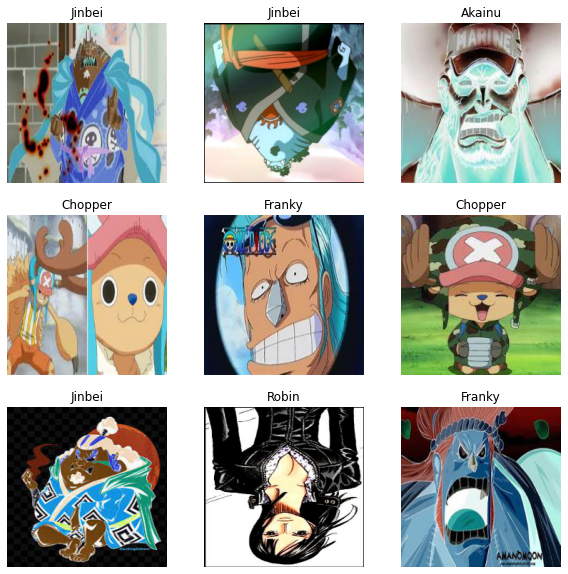

In [34]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [35]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


### Split Validation data to Test data

In [36]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 56
Number of test batches: 14


## Configure data performance for Training

In [39]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(buffer_size=1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Create Augmentation Layers

In [48]:
data_augmentation = tf.keras.Sequential(
    layers=[
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape=IMG_SIZE + (3,)),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
        tf.keras.layers.experimental.preprocessing.RandomZoom(-0.1)
        ], 
    name="data_augmentation"
    )

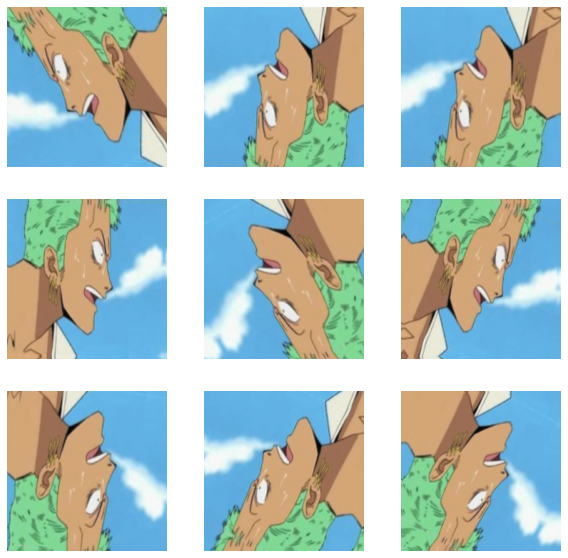

In [50]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Train Model

### Model with CNN Layers

In [51]:
def model_builder():
    """
    Generates and compiles the training model
    Returns
    -------
    model : tensorflow.keras.models.Sequential
        The training model
    """

    # Set Number Class
    num_classes = len(class_names)

    # Create the model
    model = tf.keras.Sequential()
    
    normalization_layer = tf.keras.layers.Rescaling(1./255)

    # Setup the model : add the data augmentation layer defined above
    model.add(data_augmentation)
    
    # Features detector
    model.add(normalization_layer)
    
    model.add(tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(512, activation='relu'))

    # Final output : probabilities 
    model.add(tf.keras.layers.Dense(num_classes, activation="sigmoid",name="final_output"))
    
    # Compile the model
    model.compile(
        optimizer= tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"])

    return model

In [52]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "checkpoint_CNN.h5", save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", 
                                                  patience=10, 
                                                  mode ="max", 
                                                  verbose=2, 
                                                  restore_best_weights=True)

In [53]:
model = model_builder()
print(f"Model : {model}")

Model : <keras.engine.sequential.Sequential object at 0x7f835ffc2850>


In [54]:
history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=validation_dataset,
                    callbacks=[model_checkpoint, early_stopping],
                    batch_size=64)

Epoch 1/100
278/278 [==============================] - 80s 237ms/step - loss: 2.8183 - accuracy: 0.0718 - val_loss: 2.7929 - val_accuracy: 0.0904
Epoch 2/100
278/278 [==============================] - 47s 169ms/step - loss: 2.7513 - accuracy: 0.1003 - val_loss: 2.7233 - val_accuracy: 0.1136
Epoch 3/100
278/278 [==============================] - 46s 166ms/step - loss: 2.6778 - accuracy: 0.1196 - val_loss: 2.5816 - val_accuracy: 0.1594
Epoch 4/100
278/278 [==============================] - 46s 166ms/step - loss: 2.6030 - accuracy: 0.1488 - val_loss: 2.5161 - val_accuracy: 0.1668
Epoch 5/100
278/278 [==============================] - 46s 166ms/step - loss: 2.5106 - accuracy: 0.1797 - val_loss: 2.4468 - val_accuracy: 0.2080
Epoch 6/100
278/278 [==============================] - 47s 169ms/step - loss: 2.4095 - accuracy: 0.2191 - val_loss: 2.2888 - val_accuracy: 0.2578
Epoch 7/100
278/278 [==============================] - 46s 167ms/step - loss: 2.3183 - accuracy: 0.2487 - val_loss: 2.2160 -

#### Ploting Result

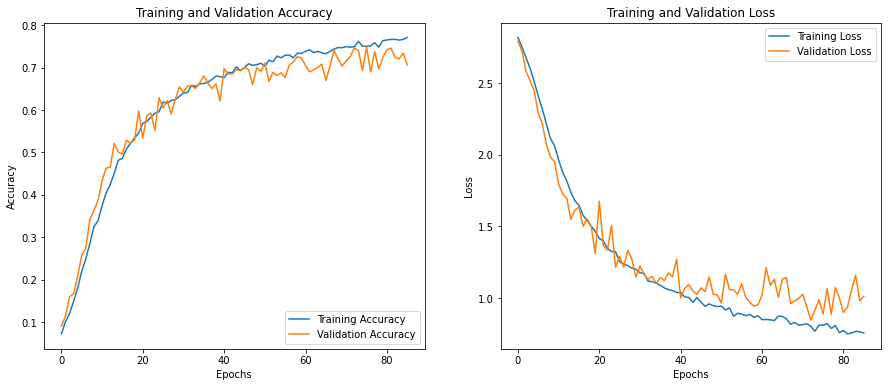

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

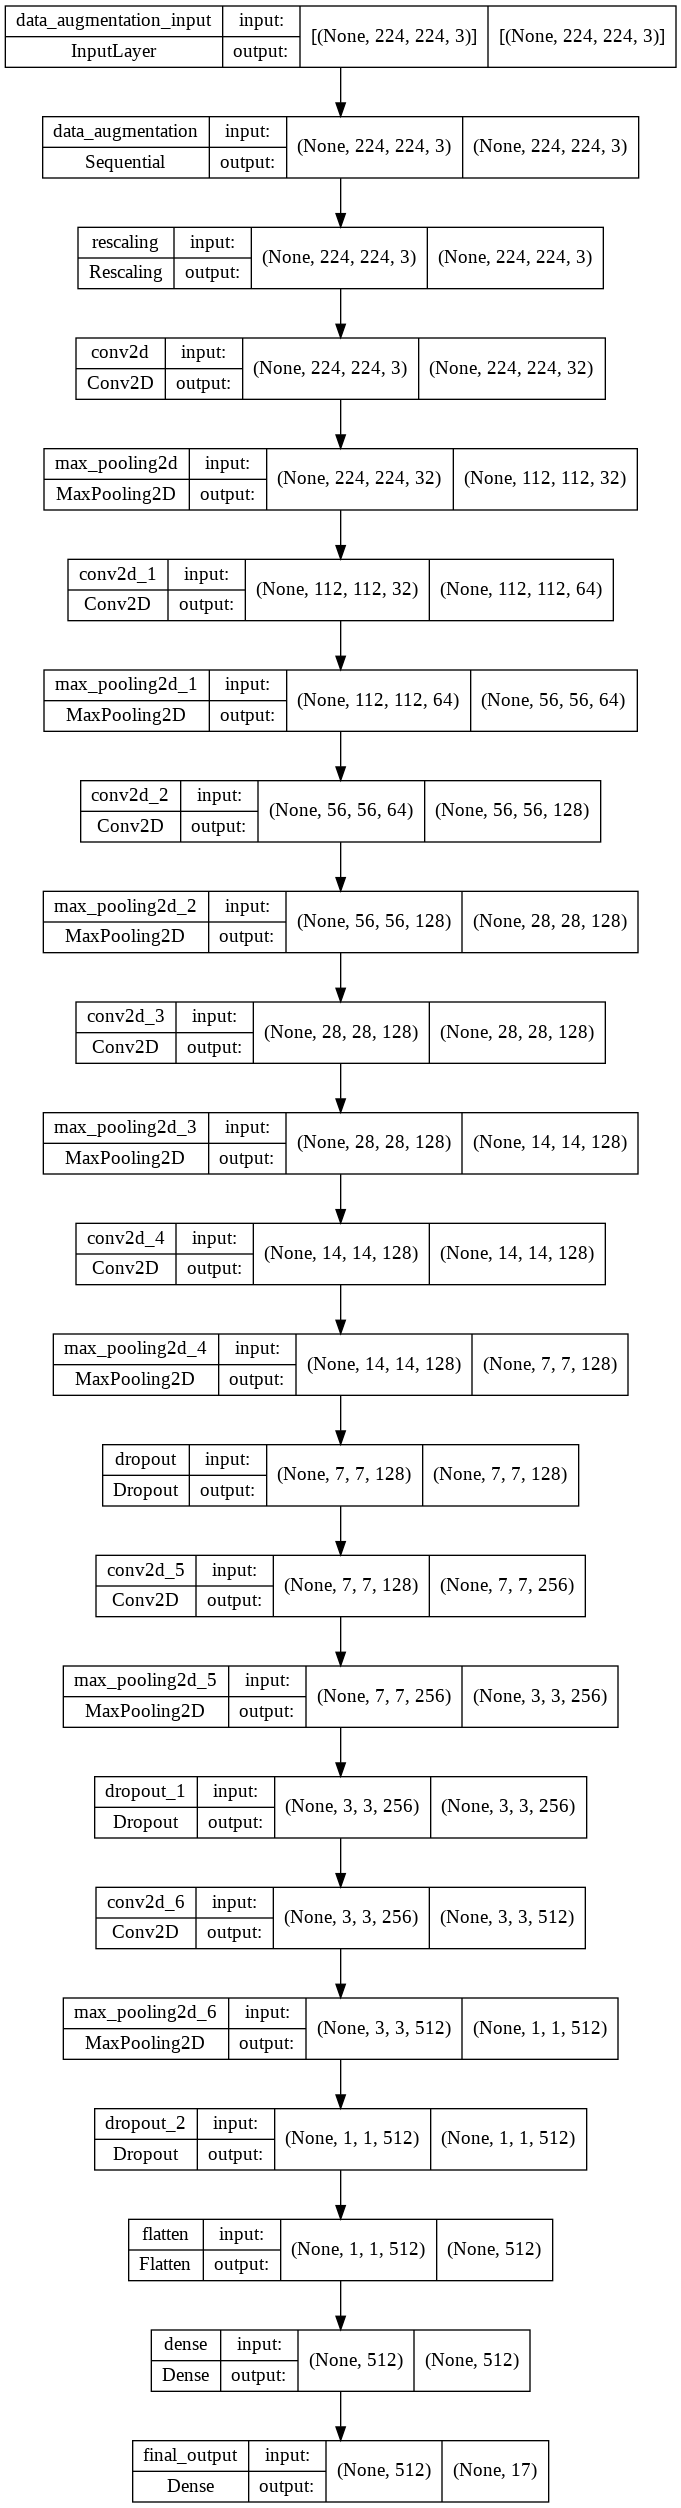

In [56]:
tf.keras.utils.plot_model(model,show_shapes=True)

#### Test Model

In [57]:
load_model = tf.keras.models.load_model('checkpoint_CNN.h5')

In [58]:
load_model.evaluate(x=validation_dataset, return_dict=True)

56/56 [==============================] - 3s 56ms/step - loss: 0.8452 - accuracy: 0.7462


{'accuracy': 0.7461842894554138, 'loss': 0.8451888561248779}

### Model with Pre-Trained Model

In [70]:
def model_builder():
    """
    Generates and compiles the training model
    Returns
    -------
    model : tensorflow.keras.models.Sequential
        The training model
    """

    # Set Number Class
    num_classes = len(class_names)

    # Create the model
    model = tf.keras.Sequential()
    
    # Load the pretrained model with its weights
    base_model = tf.keras.applications.MobileNet(input_shape= IMG_SIZE + (3,), weights="imagenet",include_top=False)
    
    # Setup the model : add the data augmentation layer defined above
    # model.add(data_augmentation)
    
    # Add the pretrained MobileNet 
    model.add(base_model)
    # Features detector
    model.add(tf.keras.layers.GlobalAveragePooling2D())  
    model.add(tf.keras.layers.BatchNormalization())
    # Fully connected layers 
    model.add(tf.keras.layers.Dense(units=1024, activation="relu"))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(units=1024, activation="relu"))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(units=512, activation="relu"))
    model.add(tf.keras.layers.Dropout(0.2))
    # Final output : probabilities 
    model.add(tf.keras.layers.Dense(num_classes, activation="sigmoid",name="final_output"))
    
    # Compile the model
    model.compile(
        optimizer= tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"])

    return model

In [71]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "checkpoint_pre_trained.h5", save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", 
                                                  patience=10, 
                                                  mode ="max", 
                                                  verbose=2, 
                                                  restore_best_weights=True)

In [72]:
model = model_builder()
print(f"Model : {model}")

Model : <keras.engine.sequential.Sequential object at 0x7f835d24bfd0>


In [73]:
history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=validation_dataset,
                    callbacks=[model_checkpoint, early_stopping],
                    batch_size=64)

Epoch 1/100
278/278 [==============================] - 126s 441ms/step - loss: 1.3565 - accuracy: 0.5989 - val_loss: 4.4094 - val_accuracy: 0.3420
Epoch 2/100
278/278 [==============================] - 122s 439ms/step - loss: 0.6987 - accuracy: 0.8108 - val_loss: 1.0662 - val_accuracy: 0.7032
Epoch 3/100
278/278 [==============================] - 121s 436ms/step - loss: 0.5196 - accuracy: 0.8621 - val_loss: 1.0708 - val_accuracy: 0.7191
Epoch 4/100
278/278 [==============================] - 122s 440ms/step - loss: 0.4076 - accuracy: 0.8954 - val_loss: 0.9001 - val_accuracy: 0.7750
Epoch 5/100
278/278 [==============================] - 122s 437ms/step - loss: 0.3565 - accuracy: 0.9057 - val_loss: 0.8183 - val_accuracy: 0.8248
Epoch 6/100
278/278 [==============================] - 121s 436ms/step - loss: 0.2889 - accuracy: 0.9245 - val_loss: 2.6320 - val_accuracy: 0.6637
Epoch 7/100
278/278 [==============================] - 121s 436ms/step - loss: 0.3361 - accuracy: 0.9206 - val_loss: 1

#### Ploting Result

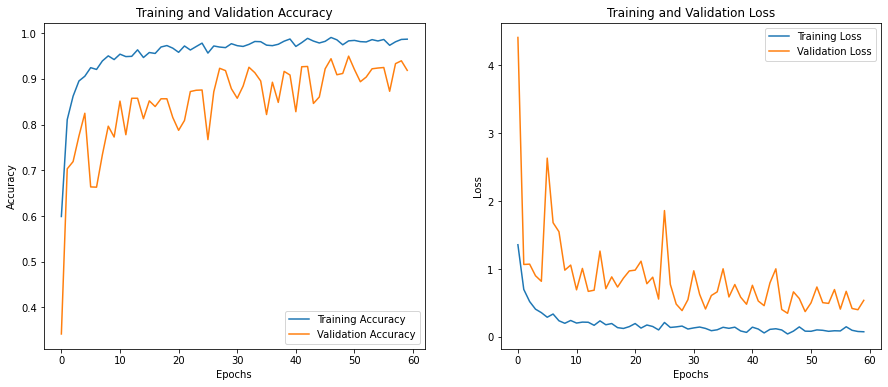

In [76]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

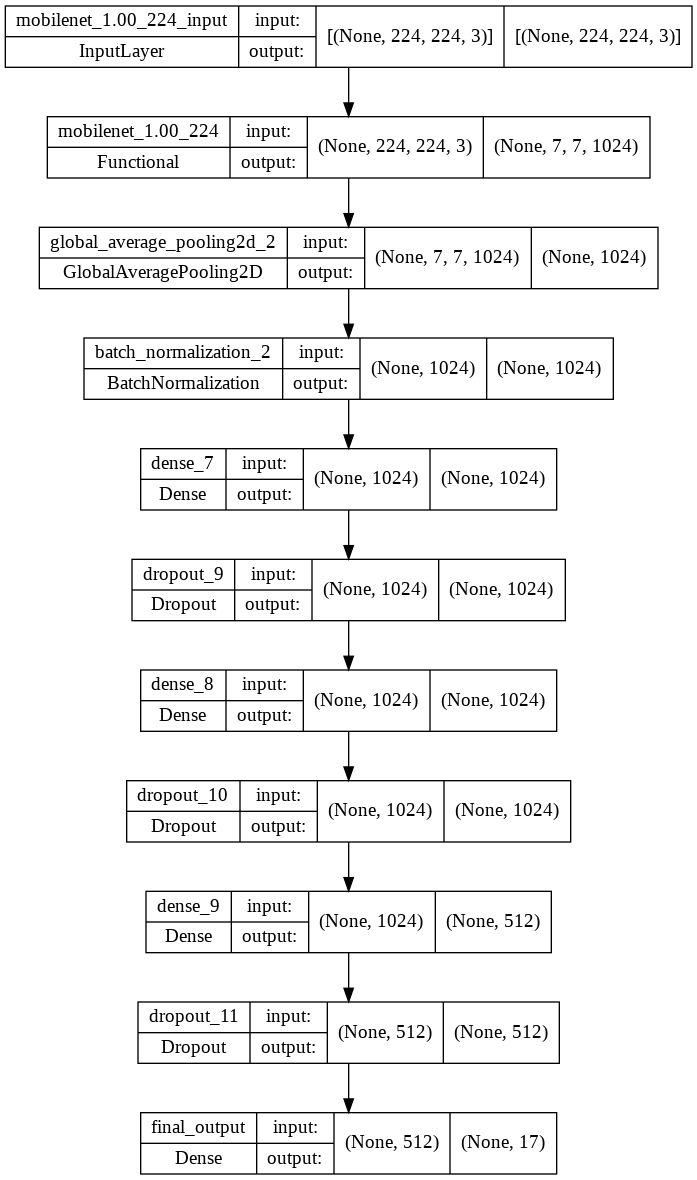

In [77]:
tf.keras.utils.plot_model(model,show_shapes=True)

#### Test Model

In [74]:
load_model_pre_trained = tf.keras.models.load_model('checkpoint_pre_trained.h5')

In [75]:
load_model_pre_trained.evaluate(x=validation_dataset, return_dict=True)

56/56 [==============================] - 6s 92ms/step - loss: 0.3469 - accuracy: 0.9440


{'accuracy': 0.9440361857414246, 'loss': 0.3468831181526184}

## Convert to TF-life

In [79]:
converter = tf.lite.TFLiteConverter.from_keras_model(load_model_pre_trained)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpfwrhbse1/assets


INFO:tensorflow:Assets written to: /tmp/tmpfwrhbse1/assets


In [81]:
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)